In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

ENABLE_UPLOAD_S3 is not set, default to False.
ENABLE_DOWNLOAD_S3 is not set, default to False.


Setting environment for Precision WorkStation


No vtk
File does not exist: /data/CSHL_data_processed/DEMO999/DEMO999_anchor.txt
File does not exist: /data/CSHL_data_processed/DEMO999/DEMO999_sorted_filenames.txt
File does not exist: /data/CSHL_data_processed/DEMO999/DEMO999_sorted_filenames.txt
File does not exist: /data/CSHL_data_processed/DEMO999/DEMO999_anchor.txt
File does not exist: /data/CSHL_data_processed/DEMO999/DEMO999_anchor.txt
File does not exist: /data/CSHL_data_processed/DEMO999/DEMO999_anchor.txt


In [2]:
from aligner_v3 import Aligner

# Global registration metrics, compared to ChAT

In [3]:
warp_setting = 0

In [4]:
global_registration_metrics_allStacks_allStructures_allLevels = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

In [5]:
for stack in ['CHATM2', 'CHATM3']:
# for stack in ['CHATM2']:
    
#     stack = 'CHATM2' # 05092018200440
    # stack = 'CHATM3' # 05092018203614

    chat_structures_df = DataManager.load_annotation_v4(stack=stack, by_human=True, 
                                                   suffix='structuresHanddrawn', 
                                                   timestamp='latest')

    chat_structures_df = chat_structures_df[~chat_structures_df['volume'].isnull()]

    chat_structures, chat_structure_resolution = \
    convert_structure_annotation_to_volume_origin_dict_v2(structures_df=chat_structures_df, 
                                                          out_resolution='10.0um', stack=stack)

    for name_s, (v_chat_10um, o_chat_10um) in sorted(chat_structures.items()):
        print stack, name_s

        chat_centroid_10um = get_centroid_3d(v_chat_10um) + o_chat_10um

        stack_m_spec = dict(name='atlasV6',
                       vol_type='score',
                       structure=name_s,
                        resolution='10.0um'
                       )

        stack_f_spec = dict(name=stack,
                           vol_type='score',
                           detector_id=799,
                           structure=convert_to_original_name(name_s),
                            resolution='10.0um'
                           )

        local_alignment_spec = dict(stack_m=stack_m_spec, 
                              stack_f=stack_f_spec,
                              warp_setting=warp_setting)

        v_alg, o_alg = DataManager.load_transformed_volume_v2(alignment_spec=local_alignment_spec, 
                                                      return_origin_instead_of_bbox=True)
    
        mask_chat = v_chat_10um > 0
        mask_atlas = crop_and_pad_volume(v_alg, 
                             in_origin=o_alg.astype(np.int) - o_chat_10um.astype(np.int),
                             out_bbox=(0, v_chat_10um.shape[1]-1, 
                                       0, v_chat_10um.shape[0]-1, 
                                       0, v_chat_10um.shape[2]-1))

        for level in np.arange(0.1, 1.1, 0.1):
            jac = jaccard_masks(mask_atlas >= level, mask_chat, wrt_min=False)
            global_registration_metrics_allStacks_allStructures_allLevels[stack][name_s][level]['jac'] = jac
                        
            
            alg_centroid_10um = get_centroid_3d(v_alg >= level) + o_alg            
            
            centroid_diff_vec_10um = chat_centroid_10um - alg_centroid_10um
            centroid_diff_norm_um = np.linalg.norm(centroid_diff_vec_10um) * 10.
            centroid_diff_percentage = centroid_diff_norm_um / (get_structure_length_at_direction(v_chat_10um, centroid_diff_vec_10um) * 10.)

            global_registration_metrics_allStacks_allStructures_allLevels[stack][name_s][level]['centroid_diff_um'] = centroid_diff_norm_um
            global_registration_metrics_allStacks_allStructures_allLevels[stack][name_s][level]['centroid_diff_percentage'] = centroid_diff_percentage

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/CHATM2" "/home/yuncong/CSHL_labelings_v3/CHATM2" --exclude "*" --include "*structuresHanddrawn*"
return code: 0


latest timestamp:  05122018234101
CHATM2 10N_L


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


CHATM2 10N_R
CHATM2 12N
CHATM2 3N_L
CHATM2 3N_R
CHATM2 4N_L
CHATM2 4N_R
CHATM2 5N_L
CHATM2 5N_R
CHATM2 6N_L
CHATM2 6N_R
CHATM2 7N_L
CHATM2 7N_R
CHATM2 Amb_L
CHATM2 Amb_R


aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/CHATM3" "/home/yuncong/CSHL_labelings_v3/CHATM3" --exclude "*" --include "*structuresHanddrawn*"
return code: 0


latest timestamp:  05102018152000
CHATM3 10N_L
CHATM3 10N_R
CHATM3 12N
CHATM3 3N_L
CHATM3 3N_R
CHATM3 4N_L
CHATM3 4N_R
CHATM3 5N_L
CHATM3 5N_R
CHATM3 6N_L
CHATM3 6N_R
CHATM3 7N_L
CHATM3 7N_R
CHATM3 Amb_L
CHATM3 Amb_R


In [6]:
global_registration_metrics_allStacks_allStructures_allLevels.default_factory = None

## Jaccard index

In [29]:
jaccard_all_stacks_all_structures = \
{stack: {s: np.nanmax([v['jac'] for l, v in x_all_l.iteritems()]) 
         for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in global_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

In [31]:
print 'Median Jaccard index between aligned atlas and expert annotation (GLOBAL):', \
np.median([y for x in jaccard_all_stacks_all_structures.values() for y in x.values()])

Median Jaccard index between aligned atlas and expert annotation (GLOBAL): 0.10743513795057458


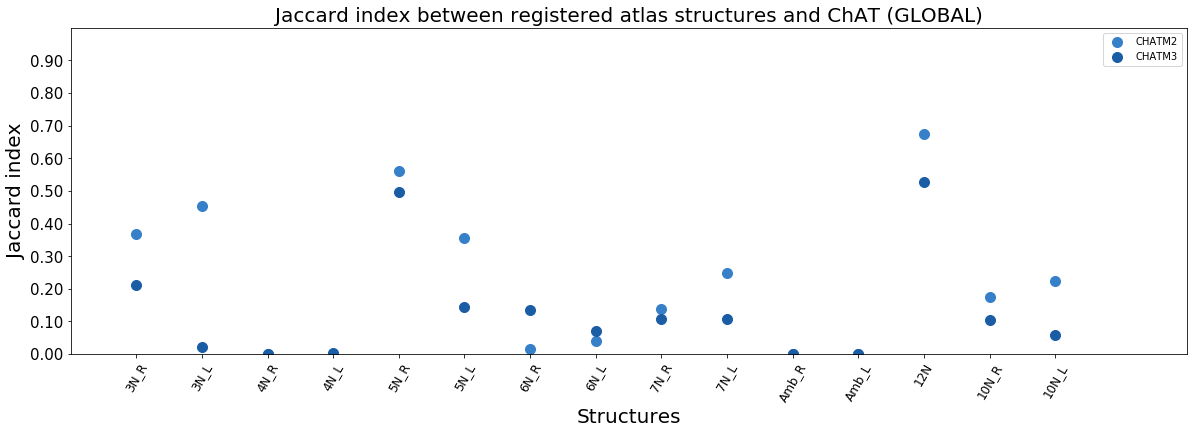

In [33]:
plot_by_stack_by_structure(jaccard_all_stacks_all_structures, 
                           structures=motor_nuclei_sided_sorted_by_rostral_caudal_position, 
                          yticks=np.arange(0, 1., .1),
                          title='Jaccard index between registered atlas structures and ChAT (GLOBAL)',
                           ylabel='Jaccard index',
                          );

## Centroid error

In [34]:
centroid_diff_all_stacks_all_structures = \
{stack: {s: np.nanmin([v['centroid_diff_um'] for l, v in x_all_l.iteritems()]) 
         for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in global_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

In [35]:
print 'Median centroid error:', \
np.nanmedian([y for x in centroid_diff_all_stacks_all_structures.values() for y in x.values()]), 'um'

Median centroid error: 209.08725434215881 um


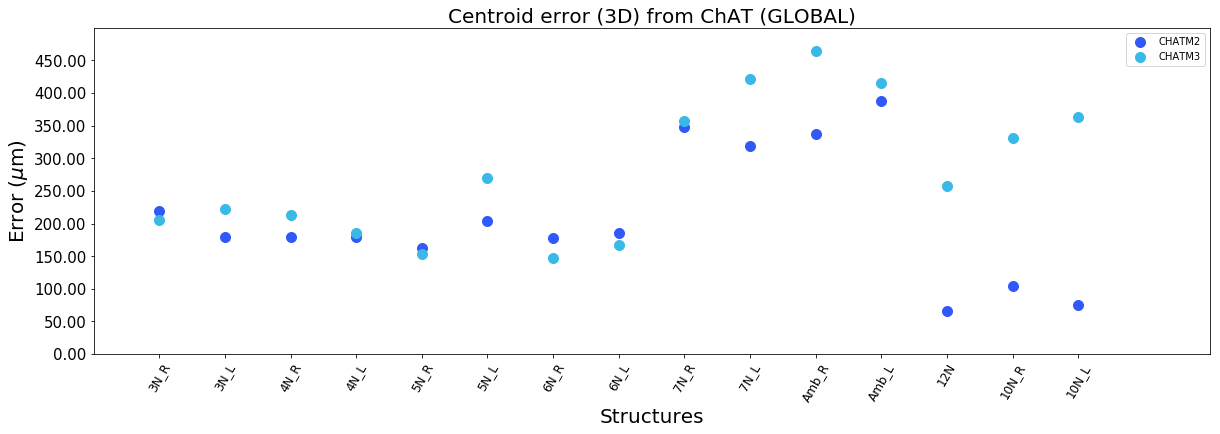

In [37]:
plot_by_stack_by_structure(centroid_diff_all_stacks_all_structures, 
                           structures=motor_nuclei_sided_sorted_by_rostral_caudal_position, 
                          yticks=np.arange(0, 500, 50),
                          title='Centroid error (3D) from ChAT (GLOBAL)',
                           ylabel='Error ($\mu$m)',
                          );

## Centroid error normalized

In [39]:
centroid_diffperc_all_stacks_all_structures = \
{stack: {s: np.nanmin([v['centroid_diff_percentage'] for l, v in x_all_l.iteritems()]) for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in global_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

In [40]:
print 'Median centroid error percentage:', \
np.nanmedian([y for x in centroid_diffperc_all_stacks_all_structures.values() for y in x.values()])

Median centroid error percentage: 0.46804447831945817


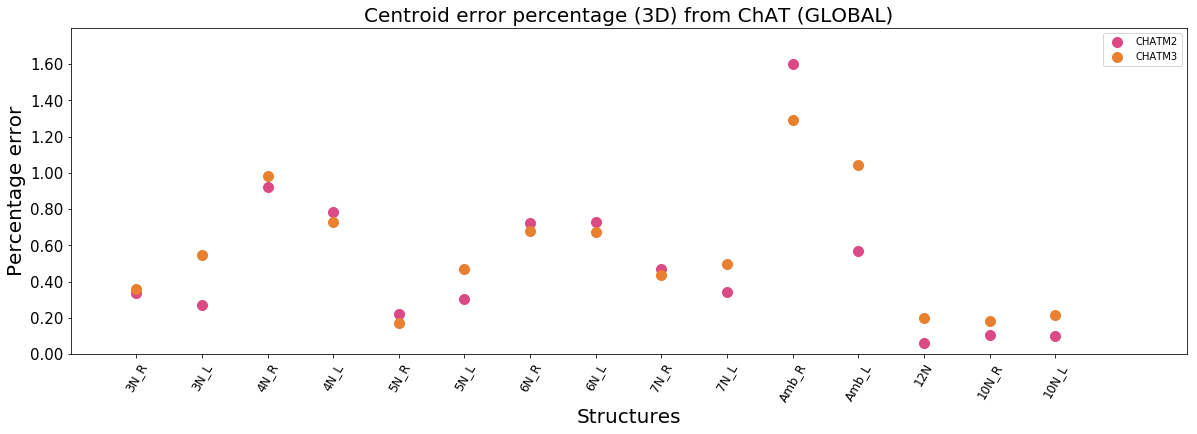

In [44]:
plot_by_stack_by_structure(centroid_diffperc_all_stacks_all_structures, 
                           structures=motor_nuclei_sided_sorted_by_rostral_caudal_position, 
                          yticks=np.arange(0, 1.7, .2),
                          title='Centroid error percentage (3D) from ChAT (GLOBAL)',
                           ylabel='Percentage error',
                          );

# Locl registration metrics, compared to ChAT

In [10]:
warp_setting = 27

In [11]:
local_registration_metrics_allStacks_allStructures_allLevels = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

In [15]:
for stack in ['CHATM2', 'CHATM3']:
# for stack in ['CHATM2']:
    
#     stack = 'CHATM2' # 05092018200440
    # stack = 'CHATM3' # 05092018203614

    chat_structures_df = DataManager.load_annotation_v4(stack=stack, by_human=True, 
                                                   suffix='structuresHanddrawn', 
                                                   timestamp='latest')

    chat_structures_df = chat_structures_df[~chat_structures_df['volume'].isnull()]

    chat_structures, chat_structure_resolution = \
    convert_structure_annotation_to_volume_origin_dict_v2(structures_df=chat_structures_df, 
                                                          out_resolution='10.0um', stack=stack)

    for name_s, (v_chat_10um, o_chat_10um) in sorted(chat_structures.items()):
        print stack, name_s

        chat_centroid_10um = get_centroid_3d(v_chat_10um) + o_chat_10um

        stack_m_spec = dict(name='atlasV6',
                       vol_type='score',
                       structure=name_s,
                        resolution='10.0um'
                       )

        stack_f_spec = dict(name=stack,
                           vol_type='score',
                           detector_id=799,
                           structure=convert_to_original_name(name_s),
                            resolution='10.0um'
                           )

        local_alignment_spec = dict(stack_m=stack_m_spec, 
                              stack_f=stack_f_spec,
                              warp_setting=warp_setting)

        v_alg, o_alg = DataManager.load_transformed_volume_v2(alignment_spec=local_alignment_spec, 
                                                      return_origin_instead_of_bbox=True)
    
        mask_chat = v_chat_10um > 0
        mask_atlas = crop_and_pad_volume(v_alg, 
                             in_origin=o_alg.astype(np.int) - o_chat_10um.astype(np.int),
                             out_bbox=(0, v_chat_10um.shape[1]-1, 0, v_chat_10um.shape[0]-1, 0, v_chat_10um.shape[2]-1))

        for level in np.arange(0.1, 1.1, 0.1):
            jac = jaccard_masks(mask_atlas >= level, mask_chat, wrt_min=False)
            local_registration_metrics_allStacks_allStructures_allLevels[stack][name_s][level]['jac'] = jac
                        
            
            alg_centroid_10um = get_centroid_3d(v_alg >= level) + o_alg            
            
            centroid_diff_vec_10um = chat_centroid_10um - alg_centroid_10um
            centroid_diff_norm_um = np.linalg.norm(centroid_diff_vec_10um) * 10.
            centroid_diff_percentage = centroid_diff_norm_um / (get_structure_length_at_direction(v_chat_10um, centroid_diff_vec_10um) * 10.)

            local_registration_metrics_allStacks_allStructures_allLevels[stack][name_s][level]['centroid_diff_um'] = centroid_diff_norm_um
            local_registration_metrics_allStacks_allStructures_allLevels[stack][name_s][level]['centroid_diff_percentage'] = centroid_diff_percentage

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/CHATM2" "/home/yuncong/CSHL_labelings_v3/CHATM2" --exclude "*" --include "*structuresHanddrawn*"
return code: 0


latest timestamp:  05122018234101
CHATM2 10N_L
CHATM2 10N_R
CHATM2 12N
CHATM2 3N_L
CHATM2 3N_R
CHATM2 4N_L
CHATM2 4N_R
CHATM2 5N_L
CHATM2 5N_R
CHATM2 6N_L
CHATM2 6N_R
CHATM2 7N_L
CHATM2 7N_R
CHATM2 Amb_L
CHATM2 Amb_R


aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/CHATM3" "/home/yuncong/CSHL_labelings_v3/CHATM3" --exclude "*" --include "*structuresHanddrawn*"
return code: 0


latest timestamp:  05102018152000
CHATM3 10N_L
CHATM3 10N_R
CHATM3 12N
CHATM3 3N_L
CHATM3 3N_R
CHATM3 4N_L
CHATM3 4N_R
CHATM3 5N_L
CHATM3 5N_R
CHATM3 6N_L
CHATM3 6N_R
CHATM3 7N_L
CHATM3 7N_R
CHATM3 Amb_L
CHATM3 Amb_R


In [16]:
local_registration_metrics_allStacks_allStructures_allLevels.default_factory = None

In [9]:
# if warp_setting == None:
#     fp = '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_with_CHAT/measurements/global_registration_metrics_allStacks_allStructures_allLevels.json'
# elif warp_setting == 27:
#     fp = '/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_with_CHAT/measurements/local_registration_metrics_allStacks_allStructures_allLevels.json'

In [8]:
# create_parent_dir_if_not_exists(fp)
# save_data(local_registration_metrics_allStacks_allStructures_allLevels, fp)

# Load

In [ ]:
local_registration_metrics_allStacks_allStructures_allLevels = load_data('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/Registration/compare_with_CHAT/measurements/local_registration_metrics_allStacks_allStructures_allLevels.json')

## Jaccard index

In [17]:
local_jaccard_all_stacks_all_structures = \
{stack: {s: np.nanmax([v['jac'] for l, v in x_all_l.iteritems()]) 
         for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in local_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

In [18]:
print 'Median Jaccard index between aligned atlas and expert annotation (LOCAL):', np.median([y for x in local_jaccard_all_stacks_all_structures.values() for y in x.values()])

Median Jaccard index between aligned atlas and expert annotation (LOCAL): 0.6008092712321889


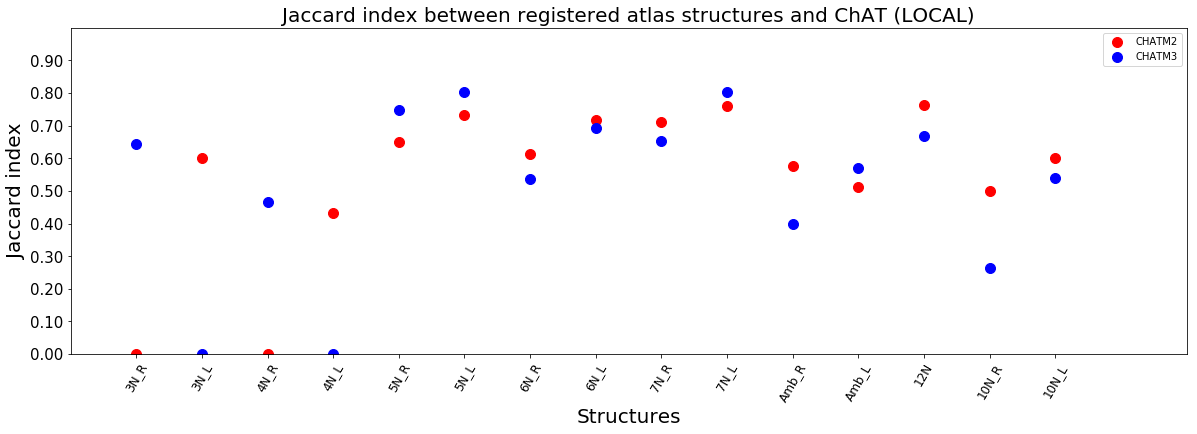

In [21]:
plot_by_stack_by_structure(local_jaccard_all_stacks_all_structures, 
                           structures=motor_nuclei_sided_sorted_by_rostral_caudal_position, 
                          yticks=np.arange(0, 1., .1),
                          title='Jaccard index between registered atlas structures and ChAT (LOCAL)',
                           ylabel='Jaccard index',
                           stack_to_color={'CHATM2': (255,0,0), 'CHATM3': (0,0,255)}
                          );

## Centroid error

In [22]:
centroid_diff_all_stacks_all_structures = \
{stack: {s: np.nanmin([v['centroid_diff_um'] for l, v in x_all_l.iteritems()]) 
         for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in local_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

In [23]:
print 'Median centroid error:', \
np.nanmedian([y for x in centroid_diff_all_stacks_all_structures.values() for y in x.values()]), 'um'

Median centroid error: 39.01528103529306 um


In [24]:
# pd.DataFrame(deviation_from_chat_um_per_structure_all_stacks).to_csv('/home/yuncong/deviation_from_chat_um_per_structure_all_stacks.csv')

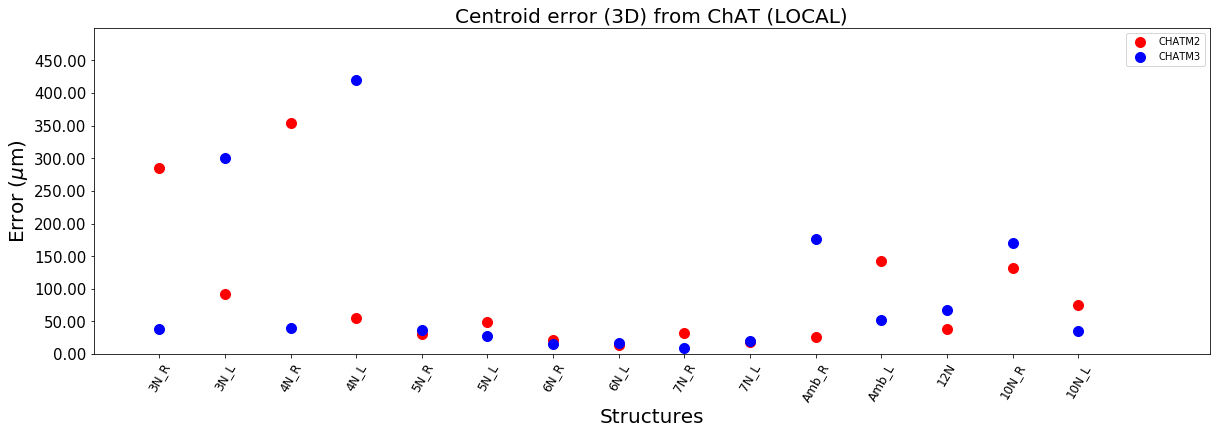

In [25]:
plot_by_stack_by_structure(centroid_diff_all_stacks_all_structures, 
                           structures=motor_nuclei_sided_sorted_by_rostral_caudal_position, 
                          yticks=np.arange(0, 500, 50),
                          title='Centroid error (3D) from ChAT (LOCAL)',
                           ylabel='Error ($\mu$m)',
                           stack_to_color={'CHATM2': (255,0,0), 'CHATM3': (0,0,255)}
                          );

## Centroid error normalized

In [26]:
centroid_diffperc_all_stacks_all_structures = \
{stack: {s: np.nanmin([v['centroid_diff_percentage'] for l, v in x_all_l.iteritems()]) for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in local_registration_metrics_allStacks_allStructures_allLevels.iteritems()}

In [27]:
print 'Median centroid error percentage:', \
np.nanmedian([y for x in centroid_diffperc_all_stacks_all_structures.values() for y in x.values()])

Median centroid error percentage: 0.08984163721032176


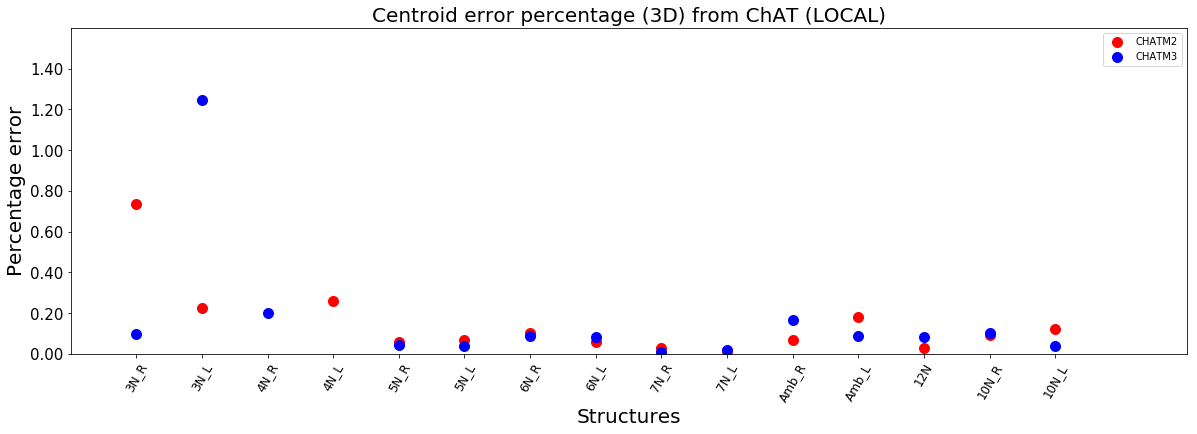

In [28]:
plot_by_stack_by_structure(centroid_diffperc_all_stacks_all_structures, 
                           structures=motor_nuclei_sided_sorted_by_rostral_caudal_position, 
                          yticks=np.arange(0, 1.5, .2),
                          title='Centroid error percentage (3D) from ChAT (LOCAL)',
                           ylabel='Percentage error',
                            stack_to_color={'CHATM2': (255,0,0), 'CHATM3': (0,0,255)}
                          );